**This problem set is due Wednesday, October 22, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

# Problem Set 06: MDPs

In this problem set, you will implement value iteration and policy iteration in a non-deterministic MDP.


0. [Credit for Contributors (required)](#contributors)

1. [Value-based MDP Solutions (60 points)](#problem1)
    1. [Value Convergence (5 points)](#convergence)
    2. [Value Iteration (25 points)](#v_iteration)
    3. [Policy Extraction (15 points)](#v_to_policy)
    4. [Policy Observations (15 points)](#policy_observations)
2. [Policy-based MDP Solutions (40 points)](#problem2)
    1. [Policy Evaluation (15 points)](#policy_evaluation)
    2. [Policy Improvement (15 points)](#policy_improvement)
    3. [Policy Iteration (10 points)](#policy_iteration)
3. [Time Spent on Pset (5 points)](#part4)
    
**100 points + 5 bonus** total for Problem Set 6

## Imports and Utilities

In [1]:
# Be sure to run the cell below to import the code needed for this assignment.
from __future__ import division

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from grid import MDPGrid, generate_mdp_plot, generate_grid_plot
from mdp_utils import MDP, build_mdp

# imports for autograder
from principles_of_autonomy.grader import Grader
from principles_of_autonomy.notebook_tests.pset_6 import TestPSet6

## <a name="contributors"></a> 0. Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat value iteration problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## <a name="problem1"></a> 1. Value-based Approaches for Solving MDPs (60 points)

In this problem, you will implement Value Iteration in a non-deterministic MDP grid world, together with a convergence function to check when the algorithm has converged. You will then implement Policy Extraction to compute the optimal policy from the optimal values calculated. Finally, you will plot the results and discuss your observations for different parameters of the MDP model.

We are giving you a simple MDP class, which is defined in the `mdp_utils.py` file. You should open this file now to look at the class definition, especially at the properties of the MDP (S, A, T, R, $\gamma$). The non-deterministic MDP model that we use is the same one described in chapter 17.1 of the AIMA book.

Concretely, the robot is in a grid world and can perform four actions at any time: `up`, `down`, `right` and `left`. However, because it's not a deterministic world, the outcome of these actions is not perfect. After executing an action, the robot will move in its intended direction with probability `p`. However, with probability `1-p` it will move at right angles to the intended direction. Note that if the outcome of the action makes the robot bump into the walls of the world, the robot will bounce back and stay in the same state. For example, from the state `(1,1)`, the action `up` moves the agent to `(1,2)` with probability 0.8, but with probability 0.1, it moves right to `(2,1)`, and with probability 0.1, it moves left, bumps into the wall, and stays in `(1,1)`.

The world is a `n x n` grid. There is a terminal goal cell. The robot receives reward `goal_reward` when it arrives in the goal cell. Similarly, there are obstacle cells. The robot receives (negative) reward `obstacle_reward` when it arrives in these cells. Both the goal and the obstacle cells are terminal: the robot can't leave these cells once it lands on them. Note: the grid world we saw in class required the agent to take an additional `Exit` action to collect its reward; we don't have that here - instead, the robot receives the reward immediately when arriving in the goal/obstacle cells.

We are providing the function `build_mdp` that generates the MDP for this grid world:

```python
def build_mdp(n, p, obstacles, goal, gamma, goal_reward=100, obstacle_reward=-1000)
```

To visualize what we're working with, let's see the MDP for a `3x3` grid with a goal state in `(2,2)` (green circle) and an obstacle in `(0,1)` (black circle).

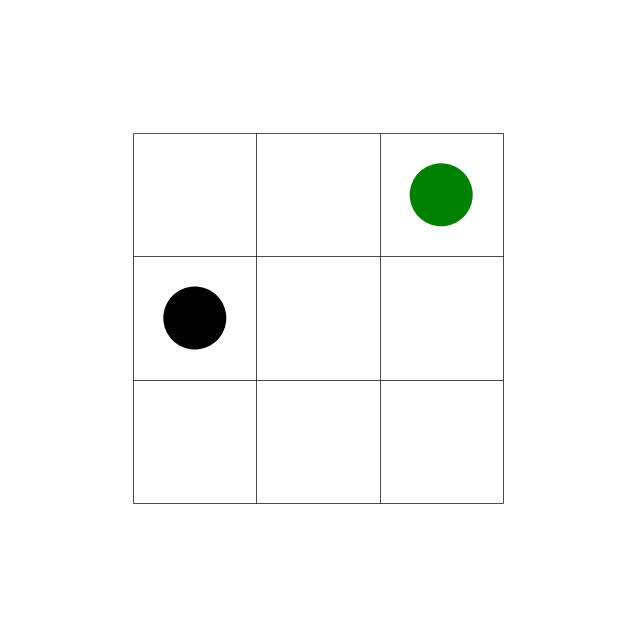

In [2]:
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Visualize the MDP:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Draw goal and obstacle cells.
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

We can also print information about the MDP that we just generated (MDP models get large pretty fast):

In [3]:
mdp.print_mdp()

MDP: 
  States (9): '(0, 1)', '(1, 2)', '(2, 1)', '(0, 0)', '(1, 1)', '(2, 0)', '(0, 2)', '(2, 2)', '(1, 0)'
  Actions (4): ['up', 'down', 'right', 'left']
  Transitions:
   + State '(0, 0)'
     -action 'up'
       to '(0, 1)' with p=0.80
       to '(1, 0)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'down'
       to '(0, 0)' with p=0.90
       to '(1, 0)' with p=0.10
     -action 'right'
       to '(1, 0)' with p=0.80
       to '(0, 1)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'left'
       to '(0, 0)' with p=0.90
       to '(0, 1)' with p=0.10
   + State '(0, 1)'
     -action 'up'
       to '(0, 1)' with p=1.00
     -action 'down'
       to '(0, 1)' with p=1.00
     -action 'right'
       to '(0, 1)' with p=1.00
     -action 'left'
       to '(0, 1)' with p=1.00
   + State '(0, 2)'
     -action 'up'
       to '(0, 2)' with p=0.90
       to '(1, 2)' with p=0.10
     -action 'down'
       to '(0, 1)' with p=0.80
       to '(1, 2)' with p=0.10
       to '(0, 

### <a name="value_convergence"></a> 1A. Check for Value Convergence (10 points)

Before we dive into implementing Value Iteration, we will first get ourselves accustomed with some values, visualize them, then implement a convergence check that will come in handy when we implement the main Value Iteration algorithm. 

We will store values as a Python dictionary that maps each state in the MDP to a value. To see an example, here's what a random Value function looks like:

In [4]:
# A random value function:
def random_V(states):
    # Initialize empty values dictionary.
    V_random = dict()
    # Generate random values between minV and maxV.
    minV, maxV = -100, 100
    for i, s in enumerate(states):
        V_random[s] = np.random.uniform(minV, maxV)
    return V_random

# Print values generated with the random Value function.
print("V_random is a valid Value function, although definitely not optimal (it's just random!)")
n = 3
mdp = build_mdp(n, 0.8, [], (1, 1), 0.8)
V_random = random_V(mdp.S)
V_random

V_random is a valid Value function, although definitely not optimal (it's just random!)


{(0, 1): -75.3550014136348,
 (1, 2): -46.935441798578424,
 (2, 1): 40.439208768675655,
 (0, 0): -6.785223394180548,
 (1, 1): -63.32720860250887,
 (2, 0): 15.40158232847682,
 (0, 2): -95.24074001687318,
 (2, 2): 89.81713788152334,
 (1, 0): 38.80533784489029}

Let's now visualize these values in the grid:

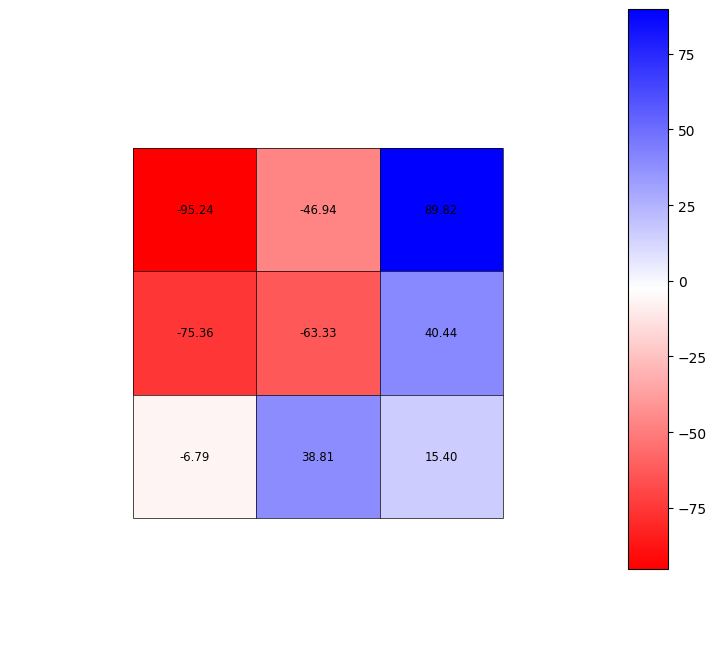

In [5]:
# Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()

# Plot V in the grid.
g.plot_V(axes, V_random, print_numbers = True)

Value Iteration is, as the name implies, an iterative procedure. In class, we saw that we can run the algorithm for a fixed number of iterations; instead, we will run it until the values converge to within $\epsilon$ from one iteration to another. Your task is to implement `value_convergence(V1, V2, epsilon)`, which takes 2 sets of values, $V_1$ and $V_2$, and checks whether for each state s the corresponding values $V_1(s)$ and $V_2(s)$ are within $\epsilon$ from one another, i.e. $|V_1(s) - V_2(s)| <= \epsilon, \forall s\in S$. If they are, the function should evaluate to True; otherwise return False.

<div class="alert alert-info">
Implement the function `value_convergence(V1, V2, epsilon)` below.
</div>

In [14]:
def value_convergence(V1: dict, V2: dict, epsilon: float) -> bool:
    for s in V1:
        if not abs(V1[s] - V2[s]) < epsilon:
            return False
    return True

In [15]:
"""Test your value convergence code here."""
Grader.run_single_test_inline(TestPSet6, "test_1_convergence", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### <a name="v_iteration"></a> 1B. Implement Value Iteration (25 points)

In this part of the problem, you will implement **Value Iteration** for a given MDP. Your function should have the following signature:

```python
def value_iteration(mdp, epsilon=1e-3)
```

The function should take an MDP instance (like the one generated by the `build_mdp` function) and a value for `epsilon` that you'll use to determine when to stop value iteration with your new convergence function. We use by default $\epsilon=10^{-3}$, but feel free to play around with the threshold and see how that changes the quality of your solution.

The function should return a Python dictionary with the optimal value for each state in the MDP. Your function should also print how many iterations it took to reach convergence for the given `epsilon` value.


<div class="alert alert-info">
Implement the function `value_iteration(mdp, epsilon=1e-3)` below.
</div>

<div class="alert alert-warning">
**Note**: Assume that if some some combination of `s`, `a` and `s_dest` is not found in the `reward` of the MDP (that is, you get an error when trying to access `mdp.R[s][a][s_dest]`, then the reward should be 0.
</div>

In [19]:
# Write your code for Value Iteration:
def value_iteration(mdp: MDP, epsilon: float = 1e-3) -> dict:
    """
    Implement value iteration.
    Returns: V, a Python dictionary of values for each state.
    """
    # Initialize all state values to zero
    V = {s: 0.0 for s in mdp.S}
    iteration = 0

    while True:
        delta = 0.0
        V_new = {}

        for s in mdp.S:
            # Compute value for each action
            action_values = []
            for a in mdp.A:
                q_sa = 0.0
                for s_next, p in mdp.T[s][a].items():
                    r = mdp.R[s][a].get(s_next, 0.0)
                    q_sa += p * (r + mdp.gamma * V[s_next])
                action_values.append(q_sa)
            V_new[s] = max(action_values)
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new
        iteration += 1

        # Robust convergence check (avoid divide-by-zero)
        if mdp.gamma == 0:
            if delta < epsilon:
                break
        else:
            if delta < epsilon * (1 - mdp.gamma) / mdp.gamma:
                break

    print(f"Converged after {iteration} iterations (ε={epsilon})")
    return V
        

Check out how your code performs on the initial grid world we defined:

Converged after 35 iterations (ε=0.001)
V:



{(0, 1): 0.0,
 (1, 2): 93.16960221799987,
 (2, 1): 93.16960221799987,
 (0, 0): 15.600575493510492,
 (1, 1): 71.45042550700019,
 (2, 0): 69.56180144517403,
 (0, 2): 26.61946335165684,
 (2, 2): 0.0,
 (1, 0): 54.603898875510744}

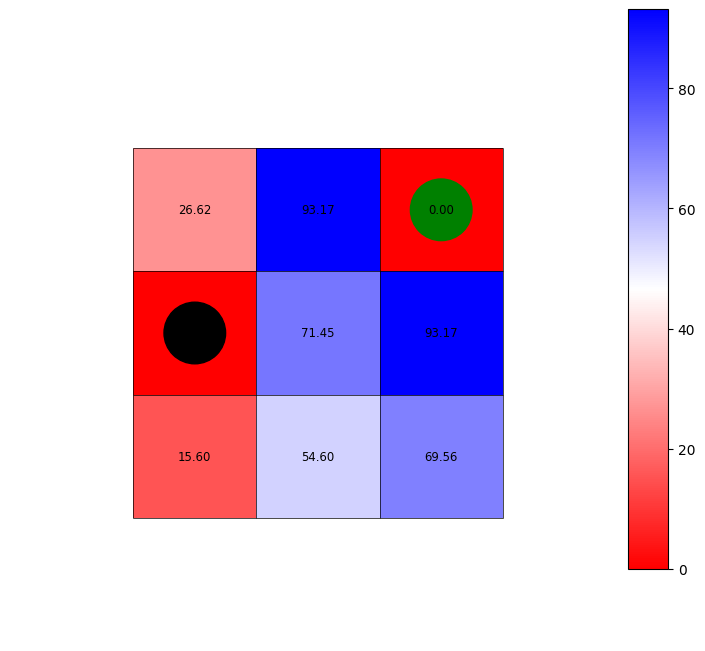

In [20]:
# Test your code for value iteration with the example from before
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Perform value iteration on the MDP.
V = value_iteration(mdp, epsilon=1e-3)

# Visualize values:
# 1. Create grid for plotting.
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot values with colors and numbers.
g.plot_V(axes, V, print_numbers=True)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

print("V:\n")
V

In [21]:
"""Test your Value Iteration code here."""
Grader.run_single_test_inline(TestPSet6, "test_2_value_iteration", locals())

Converged after 13 iterations (ε=0.001)
Converged after 35 iterations (ε=0.001)
Converged after 80 iterations (ε=0.001)
Converged after 2 iterations (ε=0.001)
Converged after 47 iterations (ε=0.001)


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.029s

OK


### <a name="v_to_policy"></a> 1C. Implement Policy Extraction (15 points)

Values are useful because they enable us to compute policies so that the robot knows what to do at every particular state. In this part of the problem, you will implement **Policy Extraction**, a procedure which, given a values dictionary, returns the optimal policy induced by those values. 

We will store policies as a Python dictionary that maps each state in the MDP to an action. To see an example, here's what a random policy looks like:

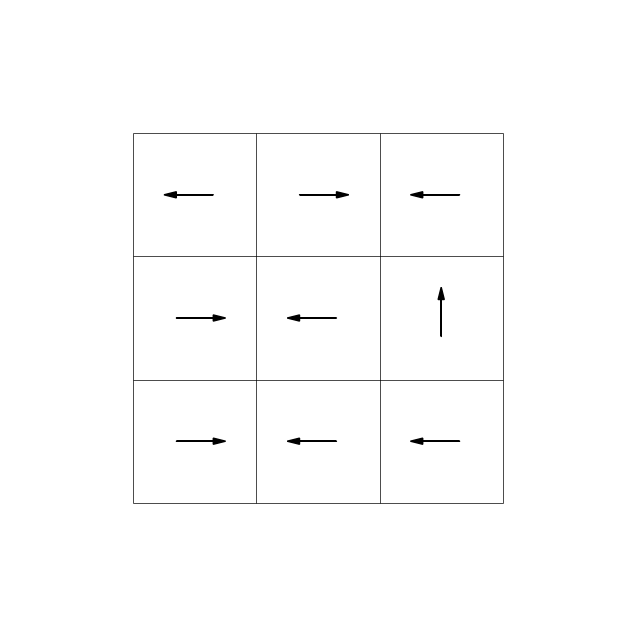

In [22]:
# A random policy:
def random_policy(states, actions):
    # Initialize empty policy dictionary.
    Pi_random = dict()
    # Designate random actions at each state.
    for i, s in enumerate(states):
        Pi_random[s] = actions[int(np.random.randint(0, len(actions)))]    
    return Pi_random

# Generate random policy for grid with no obstacles and goal in the middle.
n = 3
mdp = build_mdp(n, 0.8, [], (1,1), 0.8)
Pi_random = random_policy(mdp.S, mdp.A)

# Visualize random policy.
g = MDPGrid(n,n)
axes = g.draw()
g.plot_policy(axes, Pi_random)

Implement the function `extract_policy(mdp, V)` that extracts the optimal policy from V. Your function should have the following signature:

```python
def extract_policy(mdp, V)
```

The function takes an MDP instance and the values V out of which you'll extract the policy.

The function should return a Python dictionary mapping each state to the best action to take (e.g. `up`,`down`,`right`,`left`).

<div class="alert alert-info">
Implement the function `extract_policy(mdp, V)` below.
</div>

In [25]:
# Write your code for Policy Extraction:
def extract_policy(mdp: MDP, V: dict) -> dict:
    """
    Extract the policy from the values dictionary.
    Returns: Pi, a Python dictionary mapping states to actions.
    """
    Pi = {}

    for s in mdp.S:
        best_action = None
        best_value = -float("inf")

        # Evaluate all actions
        for a in mdp.A:
            q_sa = 0.0
            for s_next, p in mdp.T[s][a].items():
                r = mdp.R[s][a].get(s_next, 0.0)
                q_sa += p * (r + mdp.gamma * V[s_next])

            # Choose the action with the highest Q(s, a)
            if q_sa > best_value:
                best_value = q_sa
                best_action = a

        Pi[s] = best_action

    return Pi

Now we'll test both your optimal values and your optimal policy in the example we have been using:

Converged after 35 iterations (ε=0.001)


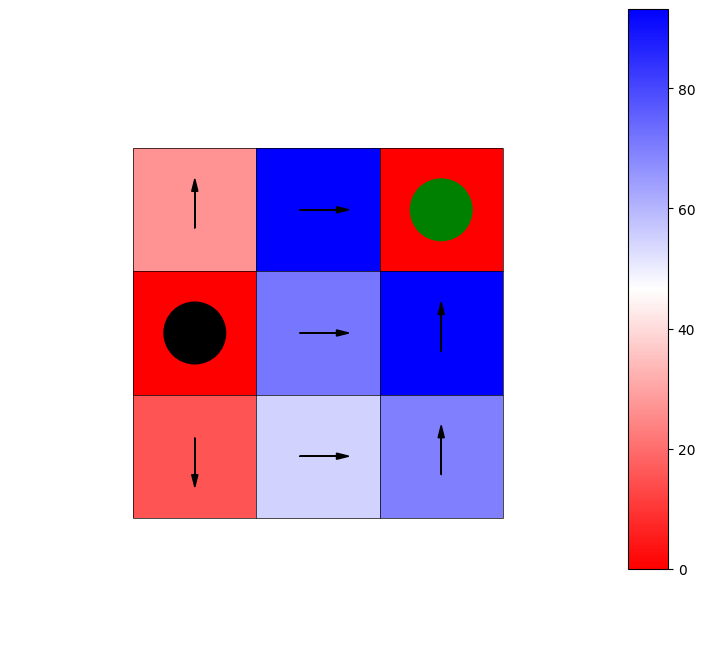

In [26]:
# Test your code for Policy Extraction with the example from before.
n = 3
goal = (2,2)
obstacles = [(0,1)]
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Perform Value Iteration to get the optimal values first.
V = value_iteration(mdp, epsilon=1e-3)
# Extract the policy from the optimal values.
Pi = extract_policy(mdp, V)

# Visualize the result.
# 1. Create grid for plotting
g = MDPGrid(n, n)
axes = g.draw()
# 2. Plot the values and the policy.
g.plot_V(axes, V, print_numbers=False)
g.plot_policy(axes, Pi)
# 3. Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

In [27]:
"""Test your Policy Extraction code here."""
Grader.run_single_test_inline(TestPSet6, "test_3_extract_policy", locals())

Converged after 13 iterations (ε=0.001)
Converged after 35 iterations (ε=0.001)
Converged after 68 iterations (ε=0.001)
Converged after 5 iterations (ε=0.001)


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.019s

OK


### <a name="policy_observations"></a> 1D. Observations (15 points)

We will now run your code on a larger grid with more obstacles and ask you qualitative questions about your solution.
Execute the following code:


Converged after 42 iterations (ε=0.001)


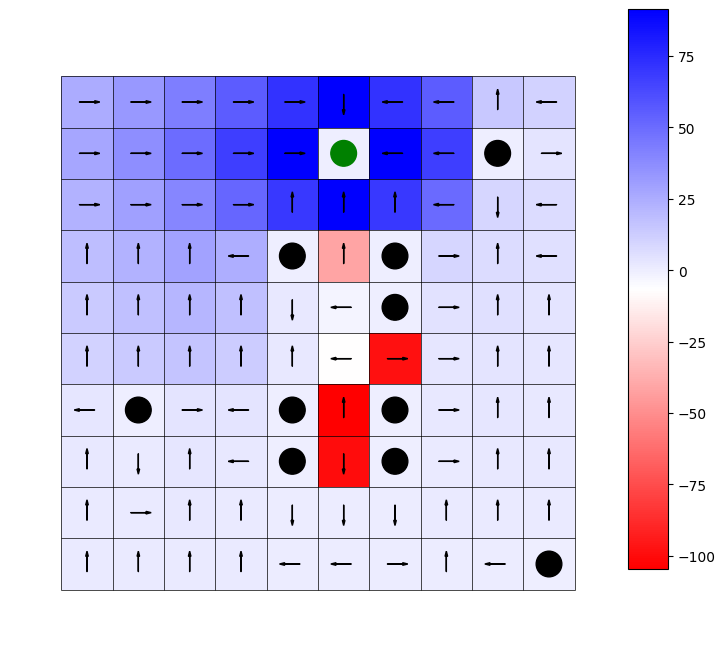

In [28]:
n = 10
goal = (5,8)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.8, goal_reward=100, obstacle_reward=-500)
V = value_iteration(mdp)
Pi = extract_policy(mdp, V)
generate_mdp_plot(mdp, V, Pi, obstacles, goal)

Does this policy look optimal? Does it look like the robot is doing something strange? Why? (hint: remember the transition model that we are using)

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

It looks mostly optimal though the robot does seem to tend to stick to the walls and avoid the middle section with obstacles. This is expected risk-aware behavior under a stochastic transition model.

Try running the previous example with a few variations of the values for `p` and `gamma`, such as:
- `p = 1.0`, `gamma = 0.99`
- `p = 1.0`, `gamma = 0.9`
- `p = 1.0`, `gamma = 0.5`
- `p = 0.8`, `gamma = 0.99`
- `p = 0.8`, `gamma = 0.9`
- `p = 0.8`, `gamma = 0.5`
- `p = 0.4`, `gamma = 0.99`
- `p = 0.4`, `gamma = 0.9`
- `p = 0.4`, `gamma = 0.5`

Think about these values affect the policy that we get. Match each combination of p and gamma to the most appropriate description of the policy behavior:

- A) p = 1.0, gamma = 0.99         
- B) p = 0.8, gamma = 0.5	
- C) p = 0.4, gamma = 0.9	
- D) p = 1.0, gamma = 0.5	

<br>

- 1\) Takes highly cautious paths to avoid uncertainty, but still values long-term rewards.       
- 2\) Takes moderately risky paths with short-term reward prioritization, balancing risk and reward.         
- 3\) Follows direct paths to maximize long-term rewards.       
- 4\) Follows direct paths, focusing on immediate rewards with little concern for the future. 

<div class="alert alert-info">
**Fill in the answer dictionary bellow with the corresponding numbers**
</div>

In [35]:
answer = {
    "A": 3,
    "B": 2,
    "C": 1,
    "D": 4
}
# raise NotImplementedError()

In [36]:
"""Test your answer."""
Grader.run_single_test_inline(TestPSet6, "test_4_observations", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## <a name="problem2"></a> 2. Policy-based Approaches for Solving MDPs (40 points)

You will now implement Policy Iteration in the same grid world environment, which involves implementing Policy Evaluation and Policy Improvement.

### <a name="policy_evaluation"></a> 2A. Implement Policy Evaluation (15 points)


In this part of the problem, you will implement **Policy Evaluation** for a given MDP. In class, we discussed two ideas for implementing this: one based on iterative updates like Value Iteration and one that uses a linear system solver. For this problem, you are NOT required to solve Policy Evaluation with a linear system solver (although you certainly can if you want to). Our cannonical solution assumes the iterative approach to Policy Evaluation.


Your function should have the following signature:

```python
def policy_evaluation(mdp, policy, epsilon=1e-3)
```

The function takes an MDP instance, a policy to evaluate, and a value for `epsilon` to check for convergence between iterations (like in Value Iteration).

The function should return a Python dictionary with the corresponding value for each state in the MDP. Your function should also print how many iterations it took to reach convergence for the given `epsilon` value. Note that these values are NOT optimal; they're just the values corresponding to whatever policy you're evaluating (which may be a random policy, which likely results in bad values). This function should look really similar to your `value_iteration` function from before (in fact, a good place to start is to just copy and paste your previous code).

<div class="alert alert-info">
Implement the function `policy_evaluation(mdp, policy, epsilon=1e-3)` below.
</div>

In [37]:
def policy_evaluation(mdp: MDP, policy: dict, epsilon: float = 1e-3) -> dict:
    """
    Perform policy evaluation to compute values for a given policy.
    Returns: V, a Python dictionary of values for each state.
    """
    # Initialize V(s) = 0 for all states
    V = {s: 0.0 for s in mdp.S}
    iteration = 0

    while True:
        delta = 0.0
        V_new = {}

        for s in mdp.S:
            a = policy[s]  # Follow the given policy
            q_sa = 0.0
            for s_next, p in mdp.T[s][a].items():
                r = mdp.R[s][a].get(s_next, 0.0)
                q_sa += p * (r + mdp.gamma * V[s_next])
            V_new[s] = q_sa

            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new
        iteration += 1

        # Robust convergence check (handle gamma=0)
        if mdp.gamma == 0:
            if delta < epsilon:
                break
        else:
            if delta < epsilon * (1 - mdp.gamma) / mdp.gamma:
                break

    print(f"Policy evaluation converged after {iteration} iterations (ε={epsilon})")
    return V

Check out how your code performs on the initial grid world we defined, with a random policy to evaluate. Run it a few times to convince yourself of the goodness (or badness) of the values corresponding to the random policy.

Policy evaluation converged after 37 iterations (ε=0.001)


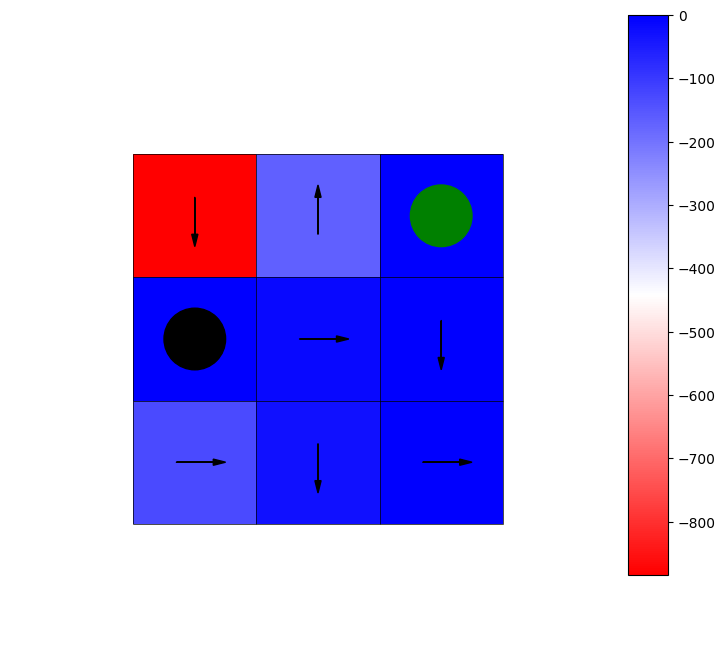

In [38]:
# Test your code for Policy Evaluation with the example from before.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Initialize random policy.
Pi_random = random_policy(mdp.S, mdp.A)

# Perform Policy Evaluation on the MDP.
V = policy_evaluation(mdp, Pi_random, epsilon=1e-3)

# Visualize values:
generate_mdp_plot(mdp, V, Pi_random, obstacles, goal)

In [39]:
"""Test your Policy Evaluation code here."""
Grader.run_single_test_inline(TestPSet6, "test_5_policy_evaluation", locals())

Policy evaluation converged after 39 iterations (ε=0.001)


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


### <a name="policy_improvement"></a> 2B. Implement Policy Improvement (15 points)

In this part, you will implement **Policy Improvement** for a given MDP and a given policy, using the values that we get from evaluating that policy.

Your function should have the following signature:

```python
def policy_improvement(mdp, policy, V)
```

The function takes an MDP instance, a policy to improve, and the resulting converged (but not optimal!) values.

The function should return a Python dictionary mapping each state to the best action to take. 

<div class="alert alert-info">
Implement the function `policy_improvement(mdp, policy, V)` below.
</div>

<div class="alert alert-warning">
**Note**: Do not modify the policy in place! Rather, return a new policy object.
</div>

In [41]:
def policy_improvement(mdp: MDP, policy: dict, V: dict) -> dict:
    """
    Improve the policy based on the value function computed.
    Returns: Pi, a Python dictionary mapping states to actions.
    """
    Pi_new = {}

    for s in mdp.S:
        best_action = None
        best_value = -float("inf")

        # Evaluate all possible actions from this state
        for a in mdp.A:
            q_sa = 0.0
            for s_next, p in mdp.T[s][a].items():
                r = mdp.R[s][a].get(s_next, 0.0)
                q_sa += p * (r + mdp.gamma * V[s_next])

            if q_sa > best_value:
                best_value = q_sa
                best_action = a

        Pi_new[s] = best_action

    return Pi_new

See how your code performs on the initial grid world, starting from a random policy. Run it a few times to convince yourself that there's an improvement.

Policy evaluation converged after 36 iterations (ε=0.001)


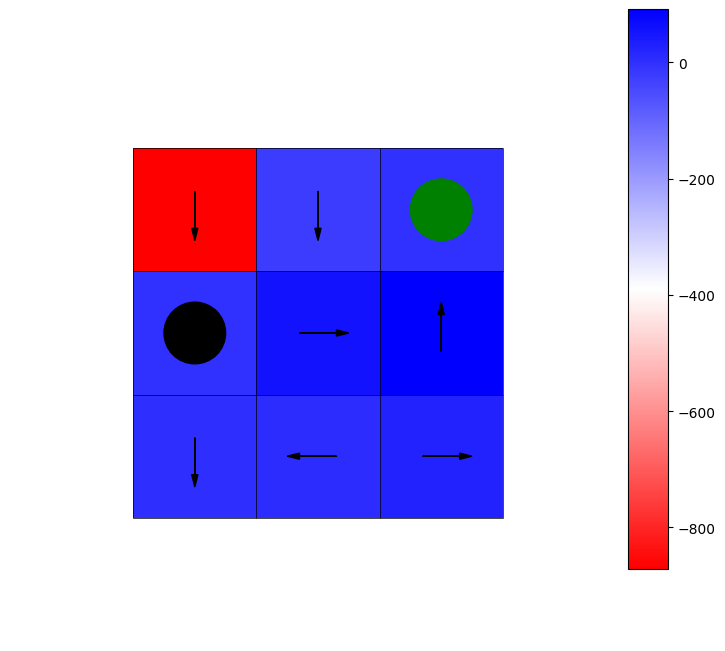

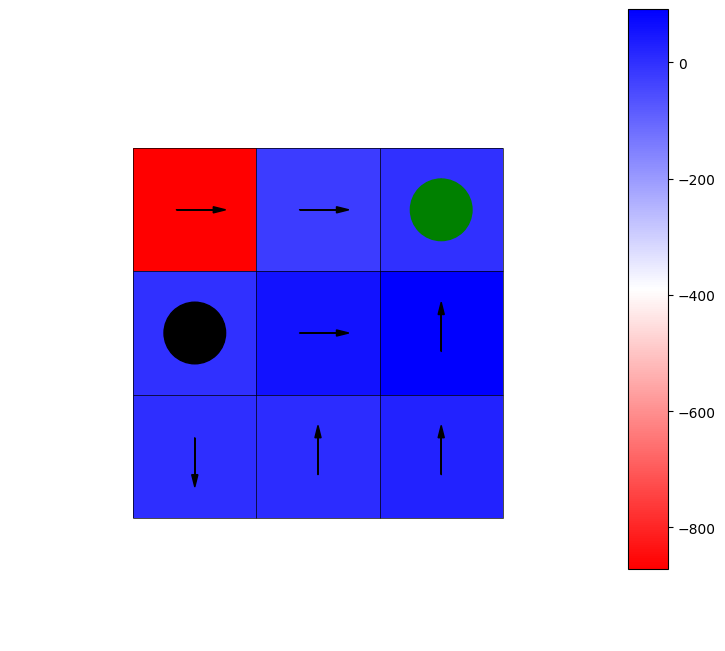

In [42]:
# Test your code for both Policy Evaluation and Policy Improvement with the example from before.
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Initialize random policy.
Pi_random = random_policy(mdp.S, mdp.A)

# Perform Policy Evaluation on the MDP.
V = policy_evaluation(mdp, Pi_random, epsilon=1e-3)

# Visualize values:
generate_mdp_plot(mdp, V, Pi_random, obstacles, goal)

# Perform Policy Improvement on the MDP with these evaluated values:
Pi_improved = policy_improvement(mdp, Pi_random, V)

# Visualize new policy:
generate_mdp_plot(mdp, V, Pi_improved, obstacles, goal)

In [43]:
"""Test your Policy Improvement code here."""
Grader.run_single_test_inline(TestPSet6, "test_6_policy_improvement", locals())

Policy evaluation converged after 39 iterations (ε=0.001)


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


### <a name="policy_iteration"></a> 2C. Implement Policy Iteration (10 points)

We finally have what we need to implement **Policy Iteration**! Given an MDP, Policy Iteration iterates (as the name suggests) between Policy Evaluation and Policy Improvement. The algorithm stops when the improved policy matches the previous policy (there is no change from Policy Improvement).

Your function should have the following signature:

```python
def policy_iteration(mdp, epsilon=1e-3)
```

The function takes an MDP instance and the `epsilon` needed for Policy Evaluation's convergence check.

The function should return both the optimal policy and the optimal values: a Python dictionary mapping each state to the best action to take, and another Python dictionary mapping each state to the optimal values. 

We will initialize the starting policy for you with a random policy.

<div class="alert alert-info">
Implement the function `policy_iteration(mdp, epsilon=1e-3)` below.
</div>

In [44]:
def policy_iteration(mdp: MDP, epsilon: float = 1e-3) -> tuple[dict, dict]:
    """
    Implement the full policy iteration algorithm.

    Return a tuple of the optimal policy and the optimal values (policy, values)
    """
    # Initialize with a random policy
    policy = random_policy(mdp.S, mdp.A)
    iteration = 0

    while True:
        iteration += 1
        # Step 1: Evaluate current policy
        V = policy_evaluation(mdp, policy, epsilon)

        # Step 2: Improve policy
        new_policy = policy_improvement(mdp, policy, V)

        # Step 3: Check for convergence (policy stable)
        if new_policy == policy:
            print(f"Policy iteration converged after {iteration} iterations.")
            break

        policy = new_policy

    return policy, V

See how your code performs on the initial grid world, starting from a random policy:

Policy evaluation converged after 38 iterations (ε=0.001)
Policy evaluation converged after 36 iterations (ε=0.001)
Policy evaluation converged after 35 iterations (ε=0.001)
Policy iteration converged after 3 iterations.


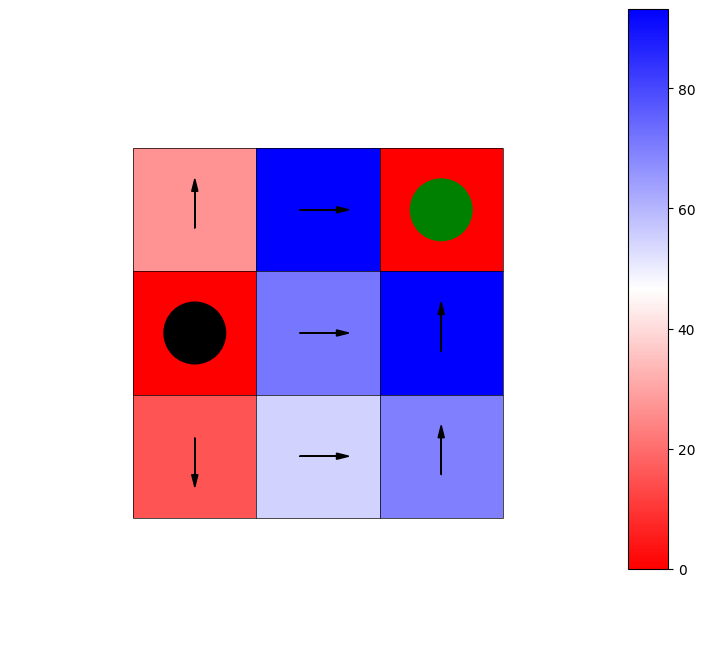

In [45]:
# Test your code for Policy Iteration with the example from before
# Don't modify this cell (it may be overwritten)
n = 3
goal = (2, 2)
obstacles = [(0, 1)]

# Build MDP with p=0.8 and gamma=0.8. Use default rewards.
mdp = build_mdp(n, 0.8, obstacles, goal, 0.8)

# Perform Policy Iteration on the MDP.
policy, V = policy_iteration(mdp)

# Visualize values:
generate_mdp_plot(mdp, V, policy, obstacles, goal)

Let's also convince ourselves that the algorithm works on the large grid world. Execute the following code:

Policy evaluation converged after 43 iterations (ε=0.001)
Policy evaluation converged after 35 iterations (ε=0.001)
Policy evaluation converged after 42 iterations (ε=0.001)
Policy evaluation converged after 43 iterations (ε=0.001)
Policy evaluation converged after 42 iterations (ε=0.001)
Policy evaluation converged after 42 iterations (ε=0.001)
Policy evaluation converged after 42 iterations (ε=0.001)
Policy iteration converged after 7 iterations.


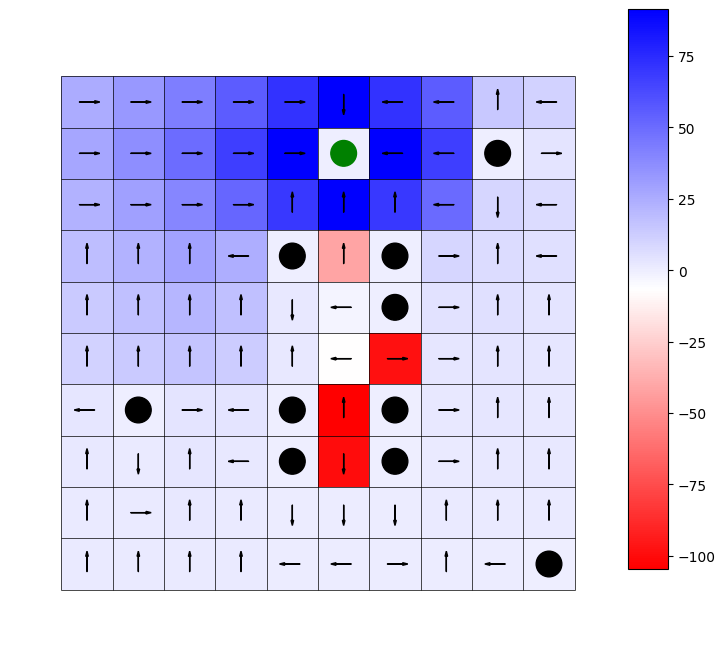

In [46]:
n = 10
goal = (5,8)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n, p=0.8, obstacles=obstacles, goal=goal, gamma=0.8, goal_reward=100, obstacle_reward=-500)
policy, V = policy_iteration(mdp)
generate_mdp_plot(mdp, V, policy, obstacles, goal)

In [47]:
"""Test your Policy Evaluation code here."""
Grader.run_single_test_inline(TestPSet6, "test_7_policy_iteration", locals())

Policy evaluation converged after 41 iterations (ε=0.001)
Policy evaluation converged after 35 iterations (ε=0.001)
Policy evaluation converged after 35 iterations (ε=0.001)
Policy iteration converged after 3 iterations.


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


## <a name="part4"></a> Time Spent on Pset (5 points)

Please use [this form](https://forms.gle/JsdXpeLKTWjAUsht7) to tell us how long you spent on this pset. After you submit the form, the form will give you a confirmation word. Please enter that confirmation word below to get an extra 5 points. 

In [49]:
form_confirmation_word = "Frigarui"

In [50]:
# Run all tests
Grader.grade_output([TestPSet6], [locals()], "results.json")
Grader.print_test_results("results.json")

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Total score is 100/100.

Score for test_1_convergence (principles_of_autonomy.notebook_tests.pset_6.TestPSet6) is 5/5.

Score for test_2_value_iteration (principles_of_autonomy.notebook_tests.pset_6.TestPSet6) is 25/25.
- Converged after 13 iterations (ε=0.001)
Converged after 35 iterations (ε=0.001)
Converged after 80 iterations (ε=0.001)
Converged after 2 iterations (ε=0.001)
Converged after 47 iterations (ε=0.001)


Score for test_3_extract_policy (principles_of_autonomy.notebook_tests.pset_6.TestPSet6) is 15/15.
- Converged after 13 iterations (ε=0.001)
Converged after 35 iterations (ε=0.001)
Converged after 68 iterations (ε=0.001)
Converged after 5 iterations (ε=0.001)


Score for test_4_observations (principles_of_autonomy.notebook_tests.pset_6.TestPSet6) is 10/10.

Score for test_5_policy_evaluation (principles_of_autonomy.notebook_tests.pset_6.TestPSet6) is 15/15.
- Policy evaluation converged after 39 iterations (ε=0.001)


Score for test_6_policy_improvement (principles_of_au

In [51]:
# Make sure you save the notebook before running this cell so that the most updated version is zipped!
Grader.prepare_submission("ProblemSet06_MDPs_release")

Open-ended responses written to ProblemSet06_MDPs_release_responses_only.ipynb
Compressed files in folder to ../ps6/ps6.zip (submit this to Gradescope)


/usr/local/lib/python3.10/dist-packages/nbformat/__init__.py:132: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
